# Exploratory Data Analysis

In this notebook, data from the Rio area-of-interest is explored to gather information about the building footprints and satellite imagery.

In [1]:
import sys
sys.path.append('src')

import path
from data import Data
from constants import *

config = DataConfig(DEFAULT_DATA_DIR, BAND3, RIO_REGION)

data = Data(config)

In [2]:
data.df[0:5]

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry,sq_ft
0,AOI_1_RIO_img5792,1,POLYGON ((408.210510077716208 39.5679995656149...,POLYGON ((-43.541791399999966 -22.876368899999...,POLYGON Z ((-43.54179139999997 -22.87636889999...,358.994749
1,AOI_1_RIO_img5792,2,POLYGON ((389.833864435032297 42.6174620222885...,POLYGON ((-43.541873799999962 -22.876382599999...,POLYGON Z ((-43.54187379999996 -22.87638259999...,691.486628
2,AOI_1_RIO_img5792,3,POLYGON ((242.119589264420313 -0.0000059554636...,POLYGON ((-43.542536143743767 -22.876191136973...,POLYGON Z ((-43.54253614374377 -22.87619113697...,2.719163
3,AOI_1_RIO_img5792,4,POLYGON ((311.733120444117787 216.147456877115...,"POLYGON ((-43.542224 -22.8771622 0,-43.5421641...","POLYGON Z ((-43.542224 -22.8771622 0, -43.5421...",219.522511
4,AOI_1_RIO_img5792,5,POLYGON ((350.582776650603819 112.220886068182...,POLYGON ((-43.542049799999972 -22.876695299999...,POLYGON Z ((-43.54204979999997 -22.87669529999...,225.812532


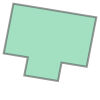

In [3]:
import shapely.wkt

sample_row = data.df.at[0, 'PolygonWKT_Pix']
shapely.wkt.loads(sample_row)

# Polygon EDA

In [4]:
data.df.sq_ft.describe()

count    255881.000000
mean        300.252492
std         728.243101
min           0.000000
25%         129.570163
50%         227.483730
75%         353.580889
max       94901.397139
Name: sq_ft, dtype: float64

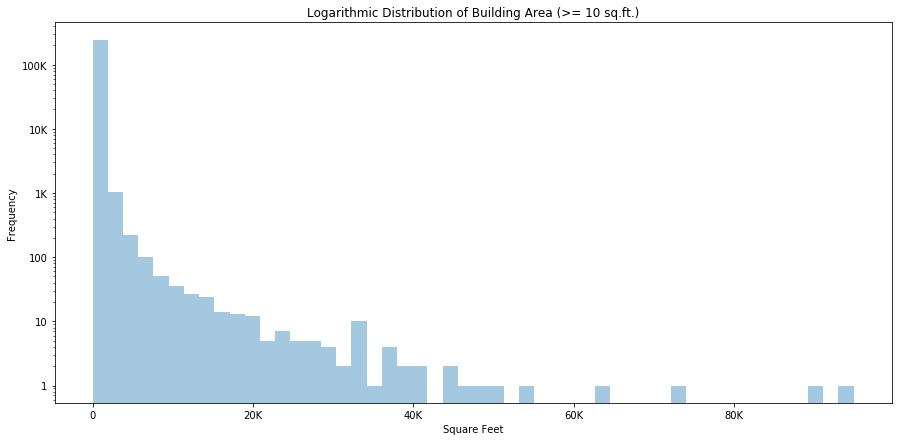

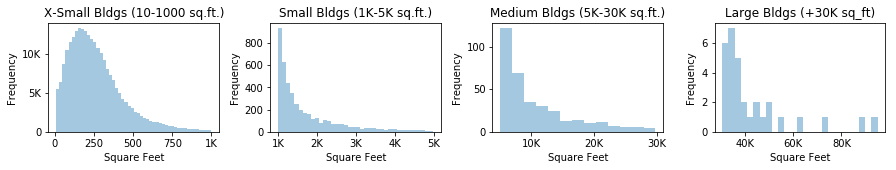

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

nonzero_sq_ft = data.df[data.df.sq_ft > 0].sq_ft

def _configure_axis(axis):
    axis.set_xlabel('Square Feet')
    axis.set_ylabel('Frequency', labelpad=5)
    axis.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: int(x)
                             if x < 1000 else '{:,.0f}'.format(x/1000) + 'K'))
    axis.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: int(x)
                             if x < 1000 else '{:,.0f}'.format(x/1000) + 'K'))

_, axis = plt.subplots(figsize=(15, 7))
axis.set_title('Logarithmic Distribution of Building Area (>= 10 sq.ft.)')
sns.distplot(nonzero_sq_ft[nonzero_sq_ft >= 10], ax=axis,
             hist_kws = dict(log=True), kde=False, rug=False)
_configure_axis(axis)

plt.figure(figsize=(15, 2))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 4, 1)
axis2 = sns.distplot(nonzero_sq_ft[(nonzero_sq_ft >= 10) &
                                   (nonzero_sq_ft < 1000)], kde=False)
axis2.set_title('X-Small Bldgs (10-1000 sq.ft.)')
_configure_axis(axis2)

plt.subplot(1, 4, 2)
axis2 = sns.distplot(nonzero_sq_ft[(nonzero_sq_ft >= 1000) &
                                   (nonzero_sq_ft < 5000)], kde=False)
axis2.set_title('Small Bldgs (1K-5K sq.ft.)')
_configure_axis(axis2)

plt.subplot(1, 4, 3)
axis3 = sns.distplot(nonzero_sq_ft[(nonzero_sq_ft >= 5000) &
                                   (nonzero_sq_ft < 30000)], kde=False)
axis3.set_title('Medium Bldgs (5K-30K sq.ft.)')
_configure_axis(axis3)

plt.subplot(1, 4, 4)
axis4 = sns.distplot(nonzero_sq_ft[nonzero_sq_ft >= 30000], bins=25, kde=False)
axis4.set_title('Large Bldgs (+30K sq_ft)')
_configure_axis(axis4)


plt.show()

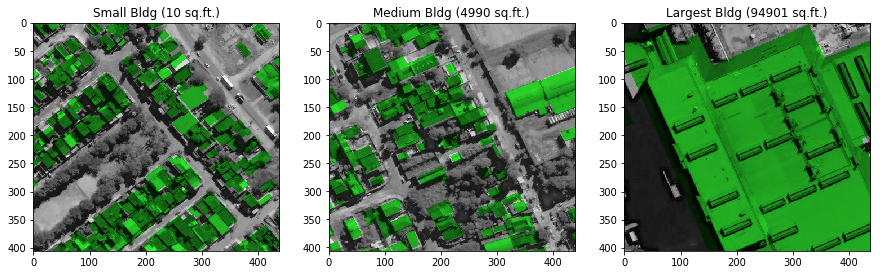

In [6]:
sq_ft_column = data.df.sq_ft

sorted_sq_ft = (data
                .df[sq_ft_column > 0]
                .sort_values('sq_ft', ascending=False))
medium = (data
          .df[(sq_ft_column > 100) & (sq_ft_column <= 5000)]
          .sort_values('sq_ft', ascending=False))

plt.figure(figsize=(15, 6))

small_row = sorted_sq_ft[sorted_sq_ft.sq_ft >= 10].iloc[-1]

plt.subplot(1, 3, 1)
plt.imshow(data.mask_overlay_for(small_row.at['ImageId']))
plt.title(f'Small Bldg ({int(small_row.sq_ft)} sq.ft.)')

plt.subplot(1, 3, 2)
plt.imshow(data.mask_overlay_for(medium.ImageId.iloc[0]))
plt.title(f'Medium Bldg ({int(medium.iloc[0].sq_ft)} sq.ft.)')

plt.subplot(1, 3, 3)
plt.imshow(data.mask_overlay_for(sorted_sq_ft.ImageId.iloc[0]))
plt.title(f'Largest Bldg ({int(sorted_sq_ft.iloc[0].sq_ft)} sq.ft.)')


plt.show()

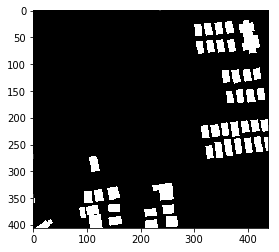

In [7]:
plt.imshow(data.mask_for('AOI_1_RIO_img5792'), cmap='gray')
plt.show()

# Data Filtering

Using the `data_filter` property, the data can be quickly filtered to produce masks that match given properties.

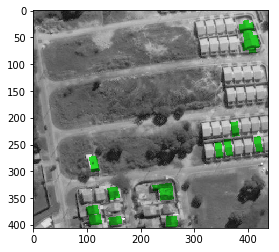

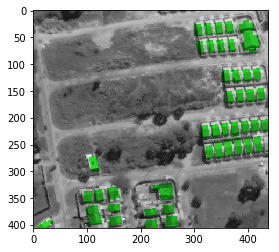

In [16]:
data.data_filter = lambda df: df.sq_ft > 250
plt.imshow(data.mask_overlay_for('AOI_1_RIO_img5792'))
plt.show()

data.data_filter = lambda df: df.sq_ft > 150
plt.imshow(data.mask_overlay_for('AOI_1_RIO_img5792'))
plt.show()

data.reset_filter()